# **Análisis Exploratorio de Datos - COLOMBIA**


In [32]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


## **Calidad de Datos**

### **Creación Variabla Ciclo Vital**

In [55]:
shp = gpd.read_file("Mapa\COLOMBIA.shp")
inc210 = pd.read_csv("tasa_inc_dengue210.csv")
inc220 = pd.read_csv("tasa_inc_dengue220.csv")
casos210 = pd.read_csv('casos_dengue_clasico.csv')
casos220 = pd.read_csv('casos_dengue_grave.csv')
col = pd.read_csv('Data/data_colombia.csv', encoding='latin1')


In [8]:
col["edad_años"] = np.where(col["uni_med"] == 1, col["edad"],   # ya está en años
                   np.where(col["uni_med"] == 2, col["edad"] / 12,  # meses → años
                   np.where(col["uni_med"] == 3, col["edad"] / 365, # días → años
                            np.nan)))  # por si hay otros valores

# Opcional: redondear a 2 decimales
col["edad_años"] = col["edad_años"].round().astype('float64')

In [9]:
def ciclo_vital(edad):
    if pd.isna(edad):
        return "Desconocido"
    elif edad < 1:
        return "Menor de 1 año"
    elif edad < 5:
        return "Primera infancia"
    elif edad < 10:
        return "Infancia"
    elif edad < 20:
        return "Adolescencia"
    elif edad < 60:
        return "Adulto"
    elif edad < 85:
        return "Adulto mayor"
    else:
        return "Ancianidad"


col["ciclo_vital"] = col["edad_años"].apply(ciclo_vital)
col['ciclo_vital'].unique()

array(['Adulto mayor', 'Adulto', 'Adolescencia', 'Ancianidad', 'Infancia',
       'Menor de 1 año', 'Primera infancia', 'Desconocido'], dtype=object)

In [10]:
col.to_csv('Data/data_colombia.csv', index=False, encoding='latin1')

### **Valores Faltantes**

In [11]:
faltantes = col.isnull().sum()
print("\n   Valores faltantes por variable:")
faltantes[faltantes > 0]


   Valores faltantes por variable:


fecha_consulta               93
fecha_hospitalizacion    546996
fecha_inicio_sintomas        53
fecha_nacimiento          30097
edad_años                    60
dtype: int64

### **Categorizar Variables**

In [14]:
col['hospitalizado'].unique()


array([1, 2])

In [15]:
col['tipo_caso'].value_counts()

tipo_caso
2    697818
3    241645
5      8347
Name: count, dtype: int64

In [16]:
mapeo = {
    'area' : {1: 'Cabecera municipal' , 2:'Centro Poblado', 3:'Rural disperso'}, 
    'hospitalizado': {1: 'Si', 2: 'No'},
    'muerte': {1: 'Vivo', 2: 'Muerto'},
    'pertenencia_etnica': {1: 'Indigena', 2: 'Rom', 3: 'Raizal', 4: 'Palenquero', 5: 'Negro', 6:'Otro'},
    'regimen_salud': {'P': 'Excepción', 'E': 'Especial', 'C': 'Contributivo', 'S': 'Subsidiado', 'N': 'No asegurado', 'I': 'Indeterminado'},
    'sexo': {'M': 'Masculino', 'F': 'Femenino'},
    'tipo_de_caso': {2: 'Probable', 3: 'Conf. por laboratorio', 5: 'Conf. por nexo'}
}

col = col.replace(mapeo)
col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947810 entries, 0 to 947809
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ano                    947810 non-null  int64  
 1   area                   947810 non-null  object 
 2   cod_dpto_o             947810 non-null  int64  
 3   cod_eve                947810 non-null  int64  
 4   cod_mun_o              947810 non-null  int64  
 5   departamento           947810 non-null  object 
 6   edad                   947810 non-null  int64  
 7   fecha_consulta         947717 non-null  object 
 8   fecha_hospitalizacion  400814 non-null  object 
 9   fecha_inicio_sintomas  947757 non-null  object 
 10  fecha_nacimiento       917713 non-null  object 
 11  fecha_notificacion     947810 non-null  object 
 12  hospitalizado          947810 non-null  object 
 13  muerte                 947810 non-null  object 
 14  municipio              947810 non-nu

## **Funciones**

In [75]:
# Mapa Tasa de Incidencia Dengue

def graficar_tasa_inc_dengue(df, shp, anio, evento=None):
    """
    Grafica la tasa de incidencia de dengue por departamento en un año específico.
    
    Parámetros:
        archivo_csv (str): ruta al CSV con las columnas [departamento, año, evento, tasa_inc_100k].
        archivo_shp (str): ruta al shapefile de Colombia.
        anio (int): año a graficar.
        evento (str, opcional): "DENGUE" o "DENGUE GRAVE". Si None, usa ambos.
    """


    # === 2. Normalizar nombres ===
    df["departamento"] = df["departamento"].str.upper().str.strip()
    shp["DPTO_CNMBR"] = shp["DPTO_CNMBR"].str.upper().str.strip()

    # === 3. Filtrar por año (y evento si se pasa como parámetro) ===
    df_anio = df[df["ano"] == anio]
    

    # === 4. Unir shapefile con datos ===
    gdf = shp.merge(df_anio, left_on="DPTO_CNMBR", right_on="departamento", how="left")

    # === 5. Graficar mapa ===
    plt.figure(figsize=(10, 12))
    gdf.plot(column="tasa_inc_100k",
             cmap="Blues",
             linewidth=0.8,
             edgecolor="black",
             legend=True,
             legend_kwds={'label': "Tasa de incidencia (por 100k habitantes)"})
    
    titulo = f"Tasa de incidencia del dengue {evento} en Colombia - {anio}"
    plt.title(titulo, fontsize=14)
    plt.axis("off")
    plt.show()


In [64]:

def graficar_evolucion_evento(df, evento, titulo=None):
    """
    Grafica la evolución semanal de casos de un evento específico (ej. 210: clásico, 220: grave).
    El eje x solo muestra el año en la semana 1.
    """

    # === 1. Asegurar tipos ===
    df["semana"] = df["semana"].astype(int)
    df["año"] = df["año"].astype(int)

    # === 2. Filtrar por evento ===
    df_evento = df[df["evento"] == evento]

    # === 3. Agrupar por semana y año ===
    agg = df_evento.groupby(["año", "semana"]).size().reset_index(name="casos")

    # === 4. Crear etiqueta semana-año ===
    agg["semana_año"] = agg["semana"].astype(str) + "-" + agg["año"].astype(str).str[-2:]

    # === 5. Ordenar cronológicamente ===
    agg = agg.sort_values(["año", "semana"]).reset_index(drop=True)

    # === 6. Graficar línea ===
    plt.figure(figsize=(18,6))
    plt.plot(agg["semana_año"], agg["casos"], marker="", linestyle="-")

    # === 7. Generar título automático ===
    if titulo is None:
        if evento == 210:
            titulo = "Evolución semanal de casos de Dengue clásico (2013–2023)"
        elif evento == 220:
            titulo = "Evolución semanal de casos de Dengue grave (2013–2023)"
        else:
            titulo = f"Evolución semanal de casos - Evento {evento} (2013–2023)"

    plt.title(titulo)
    plt.xlabel("Año")
    plt.ylabel("Número de casos")

    # === 8. Etiquetas del eje x solo en semana 1 ===
    xticks_pos = agg[agg["semana"] == 1].index  # posiciones en el DataFrame
    xticks_labels = agg.loc[agg["semana"] == 1, "año"]  # solo el año
    plt.xticks(xticks_pos, xticks_labels, rotation=45, fontsize=9)

    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [65]:
#Mapa de Casos Dengue

def mapa_casos_dengue(df, shp, anio, evento=None):
    # === 1. Normalizar nombres ===
    df["departamento"] = df["departamento"].str.upper().str.strip()
    shp["DPTO_CNMBR"] = shp["DPTO_CNMBR"].str.upper().str.strip()

    # === 2. Filtrar por año (y evento si se pasa como parámetro) ===
    df_anio = df[df["ano"] == anio]

    # === 3. Calcular casos de EXTERIOR ===
    casos_exterior = df_anio[df_anio["departamento"] == "EXTERIOR"]["casos"].sum()

    # === 4. Quitar EXTERIOR para el mapa ===
    df_anio = df_anio[df_anio["departamento"] != "EXTERIOR"]

    # === 5. Unir shapefile con datos ===
    gdf = shp.merge(df_anio, left_on="DPTO_CNMBR", right_on="departamento", how="left")

    # === 6. Graficar mapa ===
    plt.figure(figsize=(10, 12))
    gdf.plot(column="casos",
             cmap="Blues",
             linewidth=0.8,
             edgecolor="black",
             legend=True,
             legend_kwds={'label': "Casos Reportados"})

    # === 7. Título ===
    evento_str = "general" if evento is None else str(evento)
    titulo = f"Casos de dengue {evento} en Colombia - {anio}"
    plt.title(titulo, fontsize=14)

    # === 8. Agregar texto con EXTERIOR ===
    plt.text(-84, -5, f"Casos EXTERIOR: {casos_exterior}", fontsize=12, 
             bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

    plt.axis("off")
    plt.show()


In [66]:
def describir_categorica(columna, col_evento="evento"):
    # Conteos y proporciones generales
    tabla = pd.DataFrame({
        "Conteo": columna.value_counts(dropna=False),
        "Proporción": columna.value_counts(normalize=True, dropna=False).round(4)
    })

    # Renombrar índice si hay NaN
    tabla.index = tabla.index.map(lambda x: "NaN" if pd.isna(x) else x)

    # Conteos de la variable evento cruzada con la categórica
    crosstab_evento = pd.crosstab(col[columna.name], col[col_evento])

    # Unir todo
    tabla_completa = tabla.join(crosstab_evento)

    # Agregar proporciones específicas para 'Clasico' y 'Grave' si existen
    if "Clasico" in crosstab_evento.columns:
        tabla_completa["Prop_Clasico"] = (tabla_completa["Clasico"] / tabla_completa["Conteo"]).round(4)
    else:
        tabla_completa["Prop_Clasico"] = 0

    if "Grave" in crosstab_evento.columns:
        tabla_completa["Prop_Grave"] = (tabla_completa["Grave"] / tabla_completa["Conteo"]).round(4)
    else:
        tabla_completa["Prop_Grave"] = 0

    print(f"\n📌 Variable: {columna.name}")
    print(tabla_completa)
    print("\n-----------------------------------")

In [67]:
# Gráficos de variables categóricas
def graficar_categorica(var, nombre_grafico, df):
    plt.figure(figsize=(10, 4))
    plt.title(nombre_grafico, fontsize=14, fontweight='bold', pad=15)
    
    conteo = df[var].value_counts(dropna=False)
    sns.barplot(x=conteo.index.astype(str), y=conteo.values, color='steelblue')
    
    plt.xlabel("Categoría")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=0)
    plt.ylim(0, max(conteo.values) * 1.1)
    
    plt.tight_layout()
    plt.show()

In [68]:
# Gráficos de variables categóricas - Pie
def graficar_categorica_pie(var, nombre_grafico, df):
    plt.figure(figsize=(6, 4))
    plt.title(nombre_grafico, fontsize=14, fontweight='bold', pad=15)

    conteo = df[var].value_counts(dropna=False)

    # Pie chart
    plt.pie(
        conteo.values,
        labels=conteo.index.astype(str),
        autopct='%1.1f%%',   # porcentajes con 1 decimal
        startangle=90,       # para que arranque desde arriba
        colors=sns.color_palette("Blues", len(conteo))  # paleta de colores
    )

    plt.axis('equal')  # Para que sea un círculo perfecto
    plt.tight_layout()
    plt.show()

## **Análisis Univariado** 

### **Variables Demográficas** 

In [28]:
print("DESCRIPCIÓN DE VARIABLES CATEGÓRICAS")
describir_categorica(col["ciclo_vital"])
describir_categorica(col["sexo"])
describir_categorica(col["pertenencia_etnica"])
describir_categorica(col["regimen_salud"])

DESCRIPCIÓN DE VARIABLES CATEGÓRICAS

📌 Variable: ciclo_vital
                  Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
ciclo_vital                                                                   
Adulto            354532      0.3741   350418   4114        0.9884      0.0116
Adolescencia      268131      0.2829   263632   4499        0.9832      0.0168
Infancia          154055      0.1625   150961   3094        0.9799      0.0201
Primera infancia  101855      0.1075   100016   1839        0.9819      0.0181
Adulto mayor       55679      0.0587    54696    983        0.9823      0.0177
Menor de 1 año      9001      0.0095     8625    376        0.9582      0.0418
Ancianidad          4497      0.0047     4391    106        0.9764      0.0236
Desconocido           60      0.0001       59      1        0.9833      0.0167

-----------------------------------

📌 Variable: sexo
           Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
sexo                 

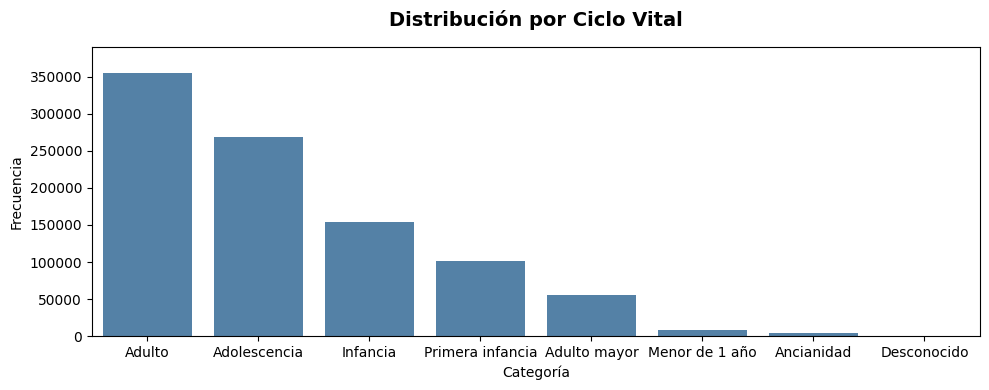

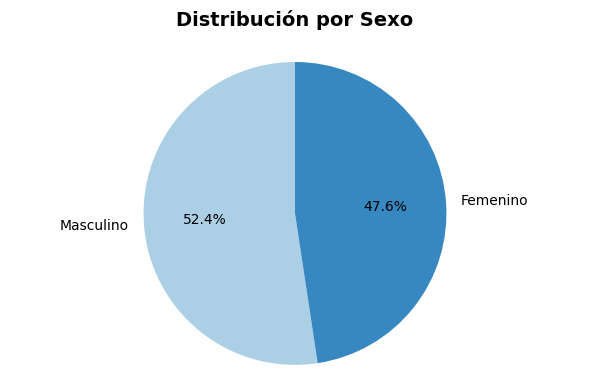

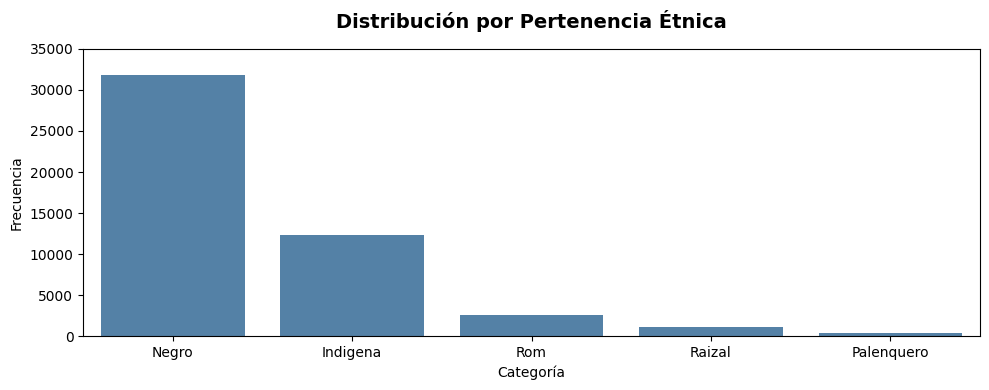

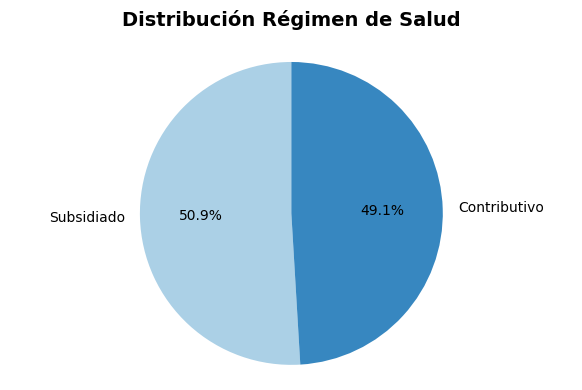

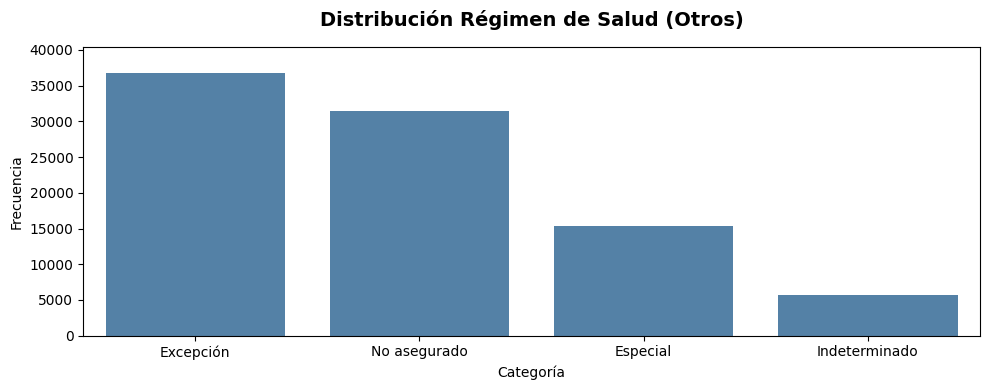

In [42]:
graficar_categorica("ciclo_vital", "Distribución por Ciclo Vital", col)
graficar_categorica_pie("sexo", "Distribución por Sexo", col)

etnia_filtrada = col[col["pertenencia_etnica"] != "Otro"]
graficar_categorica('pertenencia_etnica', "Distribución por Pertenencia Étnica", etnia_filtrada)

df_regimen_principal = col[col["regimen_salud"].isin(["Contributivo", "Subsidiado"])]
df_regimen_otros = col[~col["regimen_salud"].isin(["Contributivo", "Subsidiado"])]
graficar_categorica_pie("regimen_salud", "Distribución Régimen de Salud", df_regimen_principal)
graficar_categorica("regimen_salud", "Distribución Régimen de Salud (Otros)", df_regimen_otros)

>**Edad**

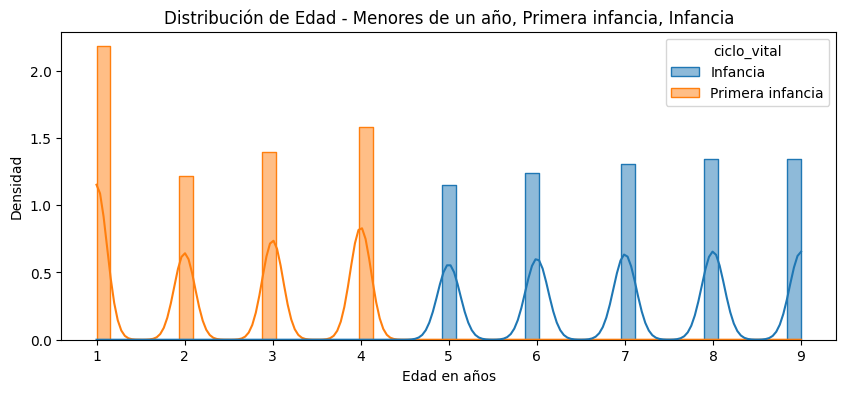

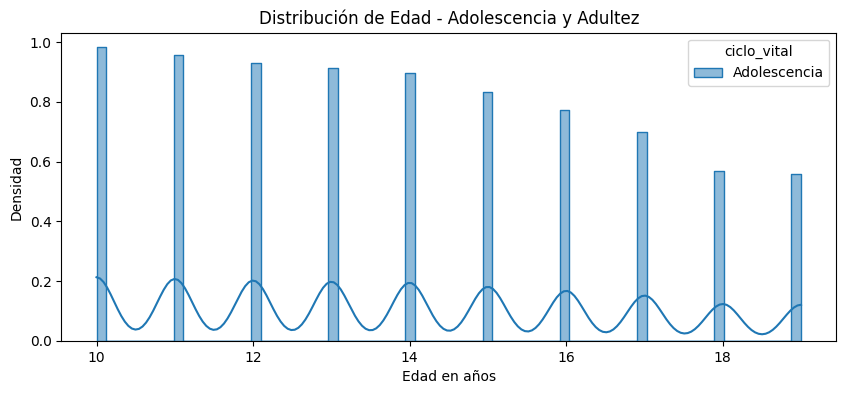

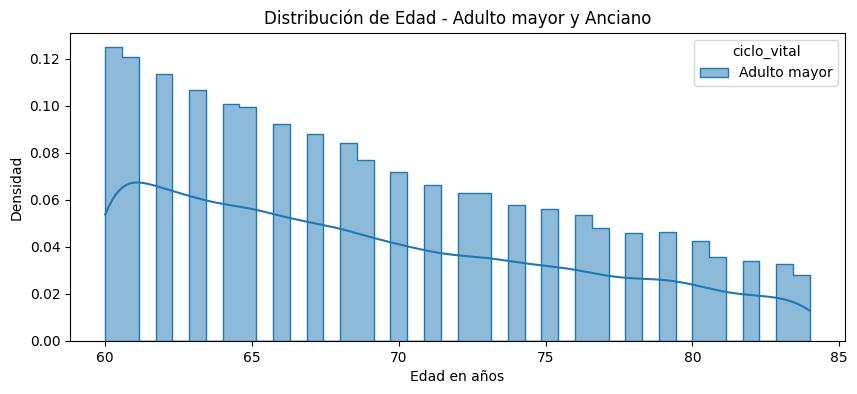

In [43]:
# Grupo 1: menores de un año, primera infancia, infancia
plt.figure(figsize=(10, 4))
sns.histplot(
    data=col[col["ciclo_vital"].isin(["Menores de un año", "Primera infancia", "Infancia"])],
    x="edad_años",
    hue="ciclo_vital",
    kde=True,
    stat="density",
    common_norm=False,
    element="step",
    alpha=0.5
)
plt.title("Distribución de Edad - Menores de un año, Primera infancia, Infancia")
plt.xlabel("Edad en años")
plt.ylabel("Densidad")
plt.show()

# Grupo 2: adolescencia y adultez
plt.figure(figsize=(10, 4))
sns.histplot(
    data=col[col["ciclo_vital"].isin(["Adolescencia", "Adultez"])],
    x="edad_años",
    hue="ciclo_vital",
    kde=True,
    stat="density",
    common_norm=False,
    element="step",
    alpha=0.5
)
plt.title("Distribución de Edad - Adolescencia y Adultez")
plt.xlabel("Edad en años")
plt.ylabel("Densidad")
plt.show()

# Grupo 3: adulto mayor y anciano
plt.figure(figsize=(10, 4))
sns.histplot(
    data=col[col["ciclo_vital"].isin(["Adulto mayor", "Anciano"])],
    x="edad_años",
    hue="ciclo_vital",
    kde=True,
    stat="density",
    common_norm=False,
    element="step",
    alpha=0.5
)
plt.title("Distribución de Edad - Adulto mayor y Anciano")
plt.xlabel("Edad en años")
plt.ylabel("Densidad")
plt.show()

In [44]:
tabla_resumen = col.groupby("ciclo_vital")["edad_años"].describe()
tabla_resumen

,count,mean,std,min,25%,50%,75%,max
ciclo_vital,,,,,,,,
Adolescencia,268131.0,13.994712,2.769073,10.0,12.0,14.0,16.0,19.0
Adulto,354532.0,34.868711,11.163998,20.0,25.0,33.0,43.0,59.0
Adulto mayor,55679.0,69.086855,6.788288,60.0,63.0,68.0,74.0,84.0
Ancianidad,4497.0,88.892595,4.250997,85.0,86.0,88.0,91.0,131.0
Desconocido,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Infancia,154055.0,7.077680,1.400671,5.0,6.0,7.0,8.0,9.0
Menor de 1 año,9001.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Primera infancia,101855.0,2.372971,1.188914,1.0,1.0,2.0,3.0,4.0


In [45]:
# Tabla para evento Clásico
tabla_clasico = col[col["evento"] == "Clasico"].groupby("ciclo_vital")["edad_años"].describe()

# Tabla para evento Grave
tabla_grave = col[col["evento"] == "Grave"].groupby("ciclo_vital")["edad_años"].describe()

print("📌 Evento: Clasico")
tabla_clasico

📌 Evento: Clasico


,count,mean,std,min,25%,50%,75%,max
ciclo_vital,,,,,,,,
Adolescencia,263632.0,13.997500,2.769913,10.0,12.0,14.0,16.0,19.0
Adulto,350418.0,34.871810,11.158698,20.0,25.0,33.0,43.0,59.0
Adulto mayor,54696.0,69.069987,6.788945,60.0,63.0,68.0,74.0,84.0
Ancianidad,4391.0,88.895240,4.272597,85.0,86.0,88.0,91.0,131.0
Desconocido,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Infancia,150961.0,7.079663,1.400805,5.0,6.0,7.0,8.0,9.0
Menor de 1 año,8625.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Primera infancia,100016.0,2.373980,1.187899,1.0,1.0,2.0,3.0,4.0


In [46]:
print("📌 Evento: Grave")
tabla_grave

📌 Evento: Grave


,count,mean,std,min,25%,50%,75%,max
ciclo_vital,,,,,,,,
Adolescencia,4499.0,13.831296,2.714721,10.0,11.0,14.0,16.0,19.0
Adulto,4114.0,34.604764,11.604925,20.0,24.0,32.0,44.0,59.0
Adulto mayor,983.0,70.025432,6.688316,60.0,64.0,69.0,75.0,84.0
Ancianidad,106.0,88.783019,3.245524,85.0,86.0,88.0,91.0,99.0
Desconocido,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Infancia,3094.0,6.980931,1.390917,5.0,6.0,7.0,8.0,9.0
Menor de 1 año,376.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Primera infancia,1839.0,2.318108,1.241929,1.0,1.0,2.0,4.0,4.0


### **Variables De Evento** 

In [48]:
describir_categorica(col['evento'])
describir_categorica(col['tipo_caso'])
describir_categorica(col['hospitalizado'])
describir_categorica(col['muerte'])


📌 Variable: evento
         Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
evento                                                               
Clasico  932798      0.9842   932798      0           1.0         0.0
Grave     15012      0.0158        0  15012           0.0         1.0

-----------------------------------

📌 Variable: tipo_caso
           Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
tipo_caso                                                              
2          697818      0.7362   688295   9523        0.9864      0.0136
3          241645      0.2550   236201   5444        0.9775      0.0225
5            8347      0.0088     8302     45        0.9946      0.0054

-----------------------------------

📌 Variable: hospitalizado
               Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
hospitalizado                                                              
No             546994      0.5771   545637   1357        0.9975 

### **Variables Espaciales** 

In [51]:
describir_categorica(col["area"])
describir_categorica(col['departamento'])


📌 Variable: area
                    Conteo  Proporción  Clasico  Grave  Prop_Clasico  \
area                                                                   
Cabecera municipal  779783      0.8227   767733  12050        0.9845   
Rural disperso       90098      0.0951    88577   1521        0.9831   
Centro Poblado       77929      0.0822    76488   1441        0.9815   

                    Prop_Grave  
area                            
Cabecera municipal      0.0155  
Rural disperso          0.0169  
Centro Poblado          0.0185  

-----------------------------------

📌 Variable: departamento
                         Conteo  Proporción  Clasico  Grave  Prop_Clasico  \
departamento                                                                
VALLE                    159224      0.1680   157096   2128        0.9866   
TOLIMA                    81910      0.0864    80285   1625        0.9802   
SANTANDER                 77715      0.0820    76862    853        0.9890   
ANTIOQUI

## **Evolución Temporal**

In [50]:
describir_categorica(col["ano"])



📌 Variable: ano
      Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
ano                                                               
2023  128102      0.1352   126382   1720        0.9866      0.0134
2013  125550      0.1325   122441   3109        0.9752      0.0248
2019  124946      0.1318   123598   1348        0.9892      0.0108
2014  107930      0.1139   105311   2619        0.9757      0.0243
2016  100970      0.1065   100071    899        0.9911      0.0089
2015   96403      0.1017    94982   1421        0.9853      0.0147
2020   77244      0.0815    76382    862        0.9888      0.0112
2022   67004      0.0707    65665   1339        0.9800      0.0200
2021   50244      0.0530    49304    940        0.9813      0.0187
2018   44156      0.0466    43637    519        0.9882      0.0118
2017   25261      0.0267    25025    236        0.9907      0.0093

-----------------------------------


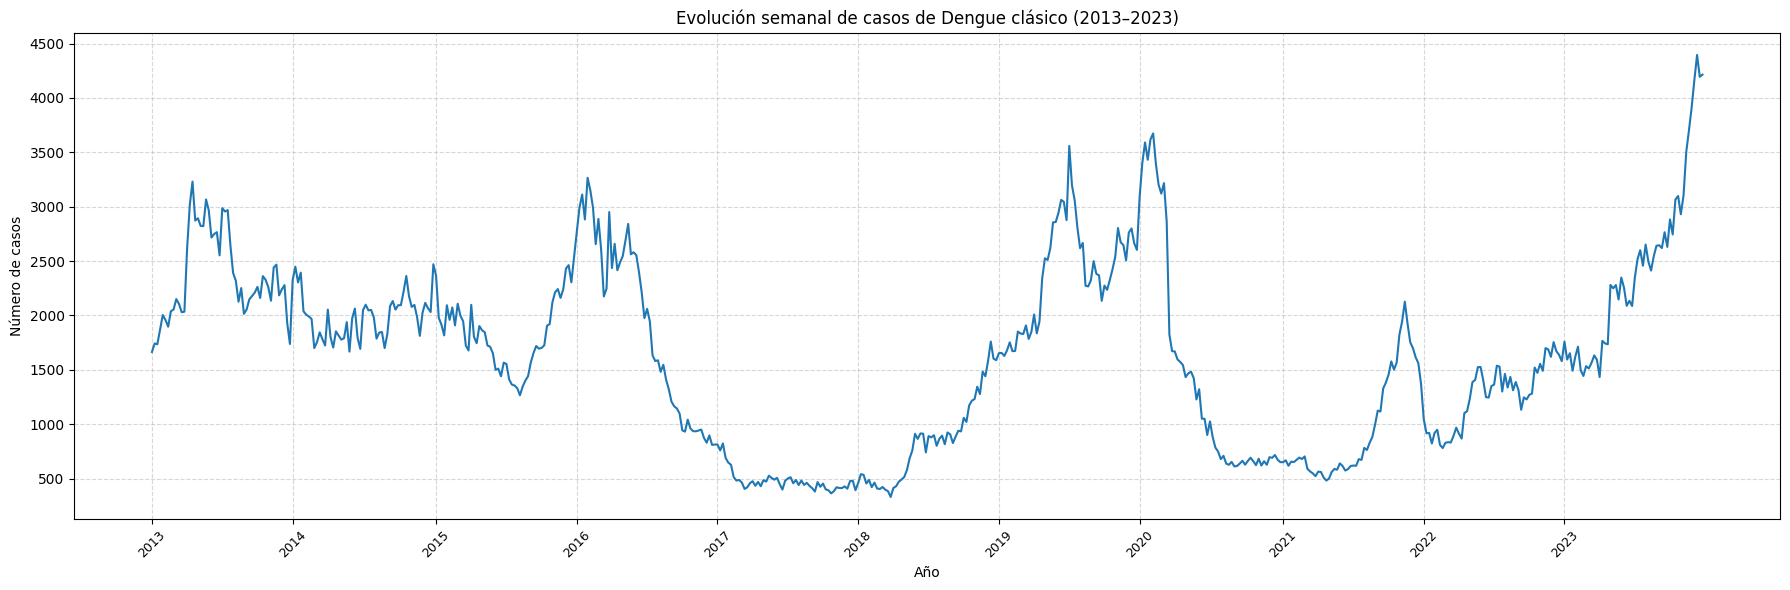

In [43]:
graficar_evolucion_evento(col, evento=210)

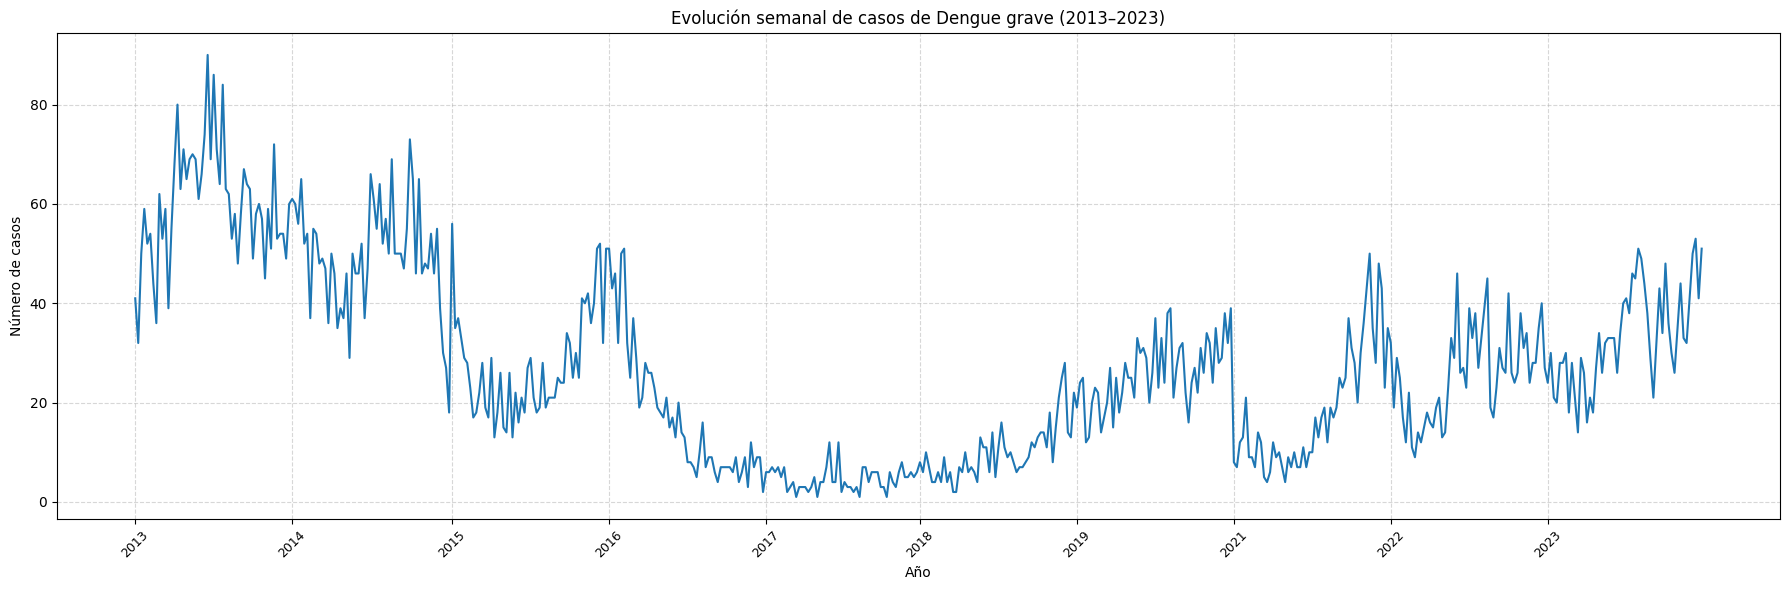

In [44]:
graficar_evolucion_evento(col, evento=220)

## **Mapas**

### **Cantidad de Casos por Evento**

<Figure size 1000x1200 with 0 Axes>

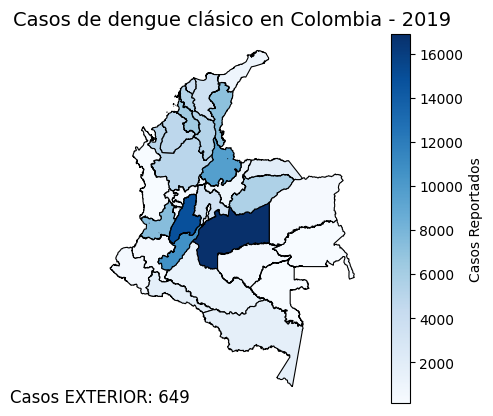

In [69]:
mapa_casos_dengue(casos210, shp, anio=2019, evento="clásico")

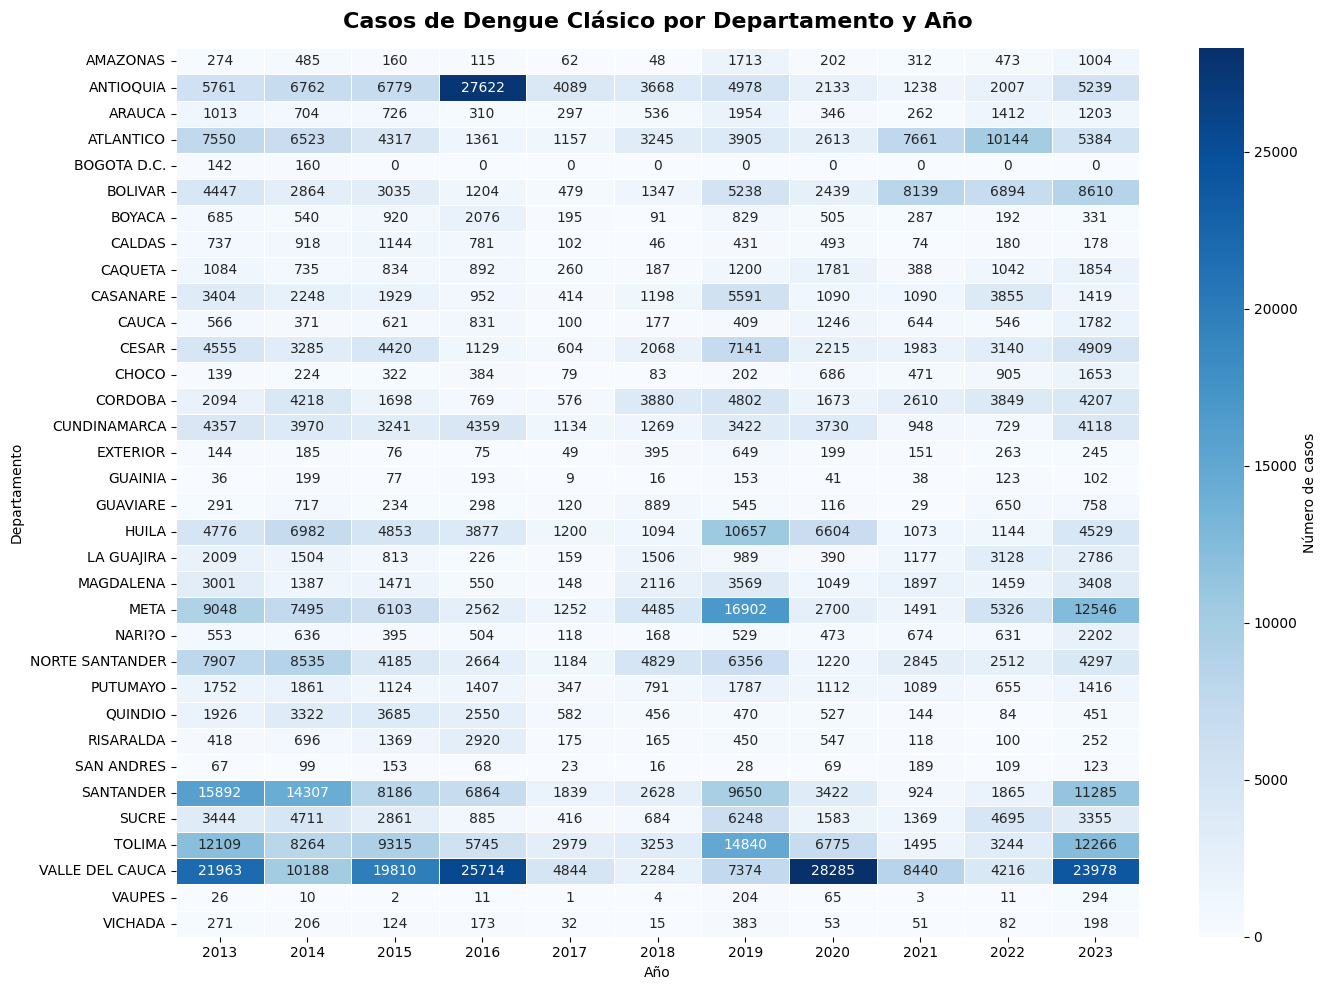

In [80]:
tabla_clasico = casos210.pivot(index="departamento", columns="ano", values="casos").fillna(0)

# === 3. Graficar heatmap ===
plt.figure(figsize=(14, 10))
sns.heatmap(tabla_clasico, cmap="Blues", annot=True, fmt=".0f", linewidths=0.5, cbar_kws={'label': 'Número de casos'})

plt.title("Casos de Dengue Clásico por Departamento y Año", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Año")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()

<Figure size 1000x1200 with 0 Axes>

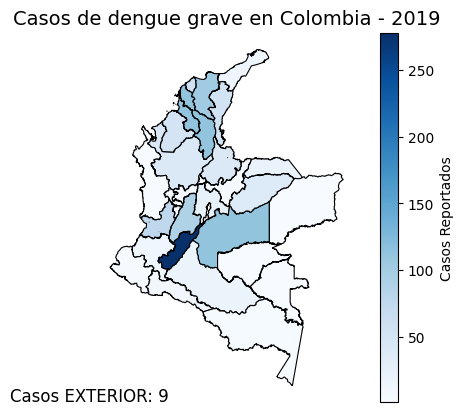

In [73]:
mapa_casos_dengue(casos220, shp, anio=2019, evento="grave")

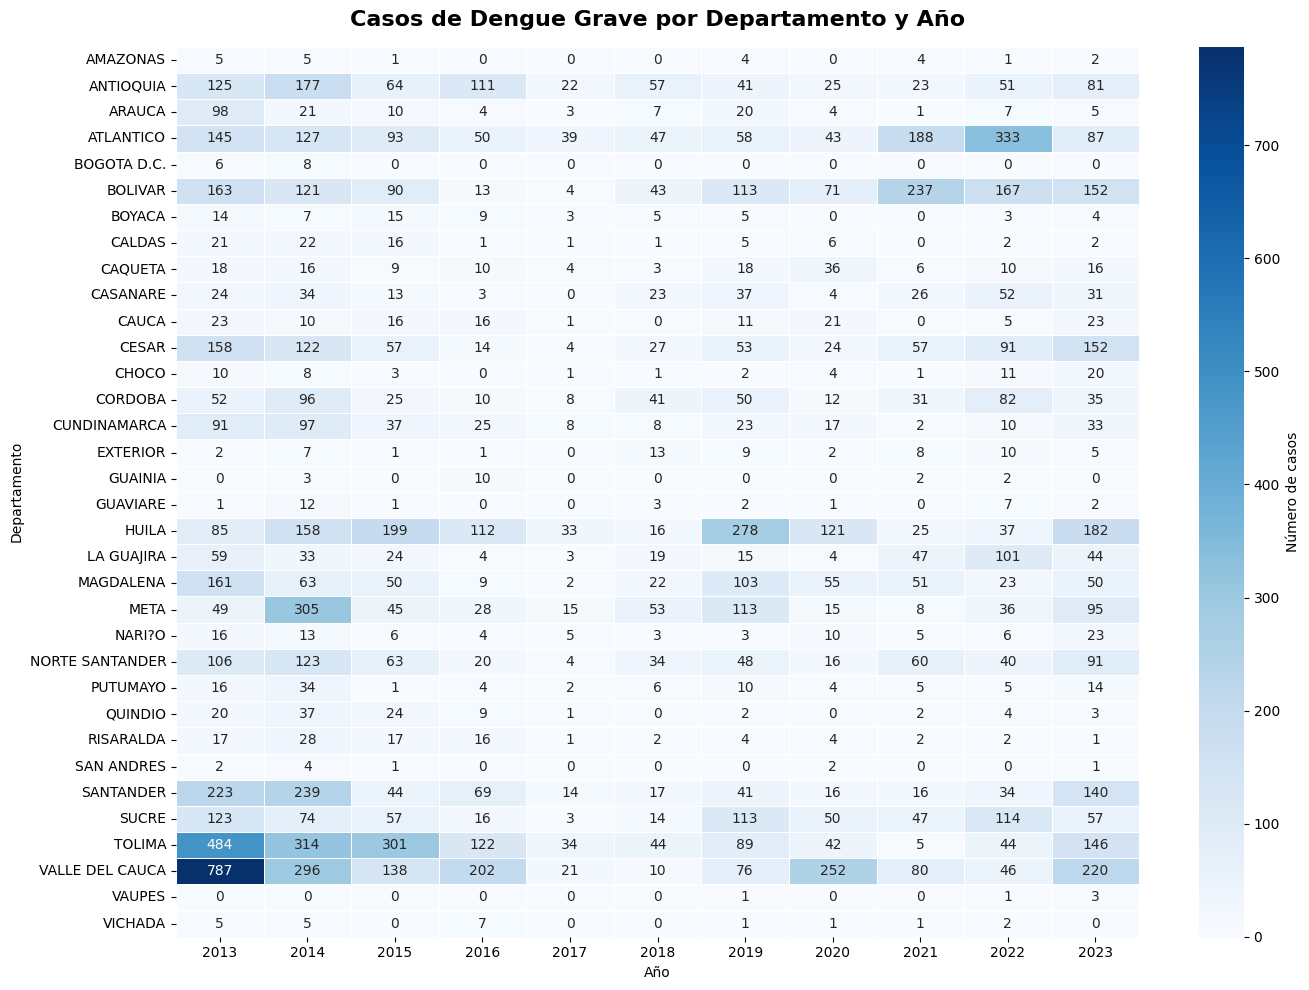

In [81]:
tabla_grave = casos220.pivot(index="departamento", columns="ano", values="casos").fillna(0)

# === 3. Graficar heatmap ===
plt.figure(figsize=(14, 10))
sns.heatmap(tabla_grave, cmap="Blues", annot=True, fmt=".0f", linewidths=0.5, cbar_kws={'label': 'Número de casos'})

plt.title("Casos de Dengue Grave por Departamento y Año", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Año")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()

### **Tasa de Incidencia por Evento**

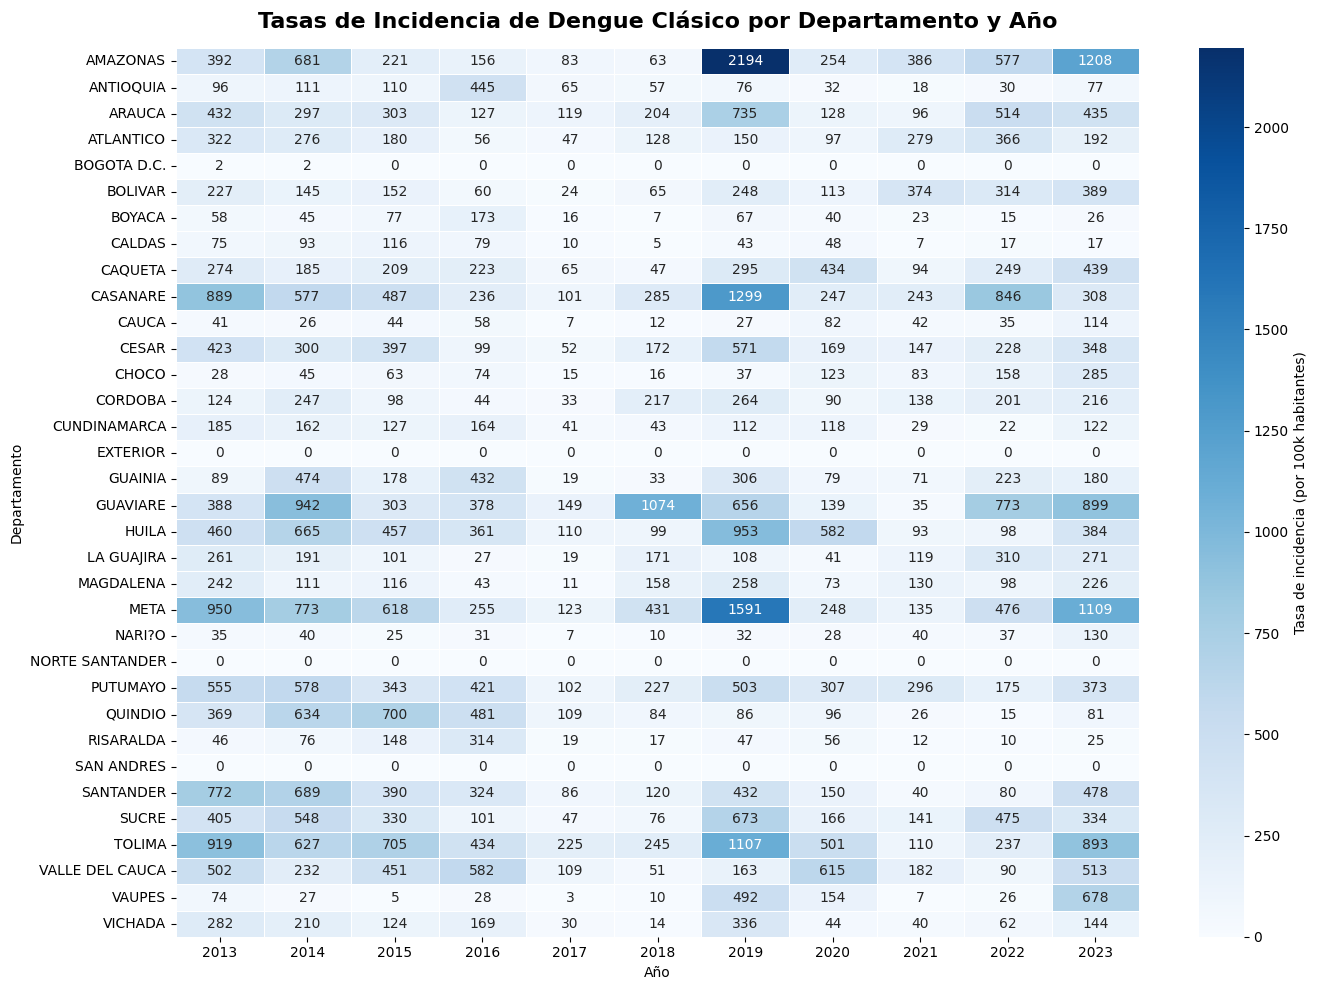

In [82]:
tabla = inc210.pivot(index="departamento", columns="ano", values="tasa_inc_100k").fillna(0)

# === 3. Graficar heatmap ===
plt.figure(figsize=(14, 10))
sns.heatmap(tabla, cmap="Blues", annot=True, fmt=".0f", linewidths=0.5, cbar_kws={'label': 'Tasa de incidencia (por 100k habitantes)'})

plt.title("Tasas de Incidencia de Dengue Clásico por Departamento y Año", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Año")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()

<Figure size 1000x1200 with 0 Axes>

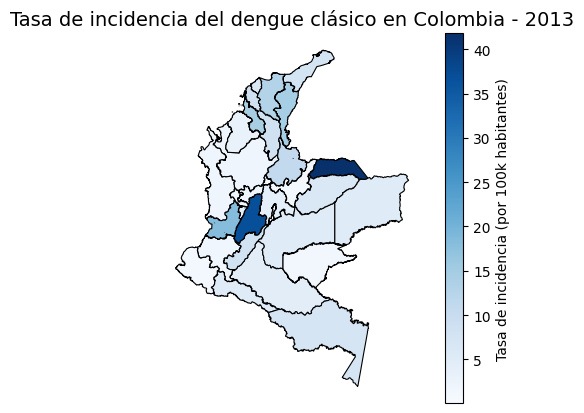

<Figure size 1000x1200 with 0 Axes>

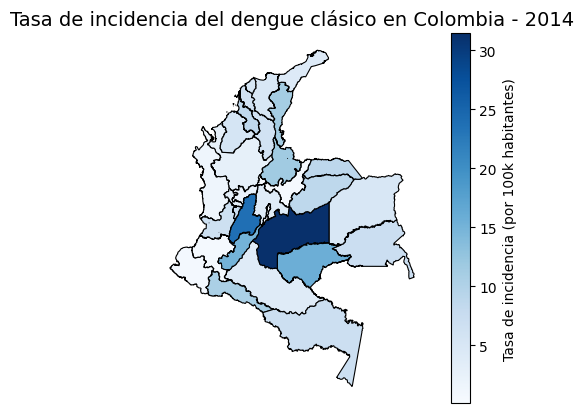

In [84]:
for anio in range(2013, 2015):
    graficar_tasa_inc_dengue(inc220, shp, anio, evento="clásico")

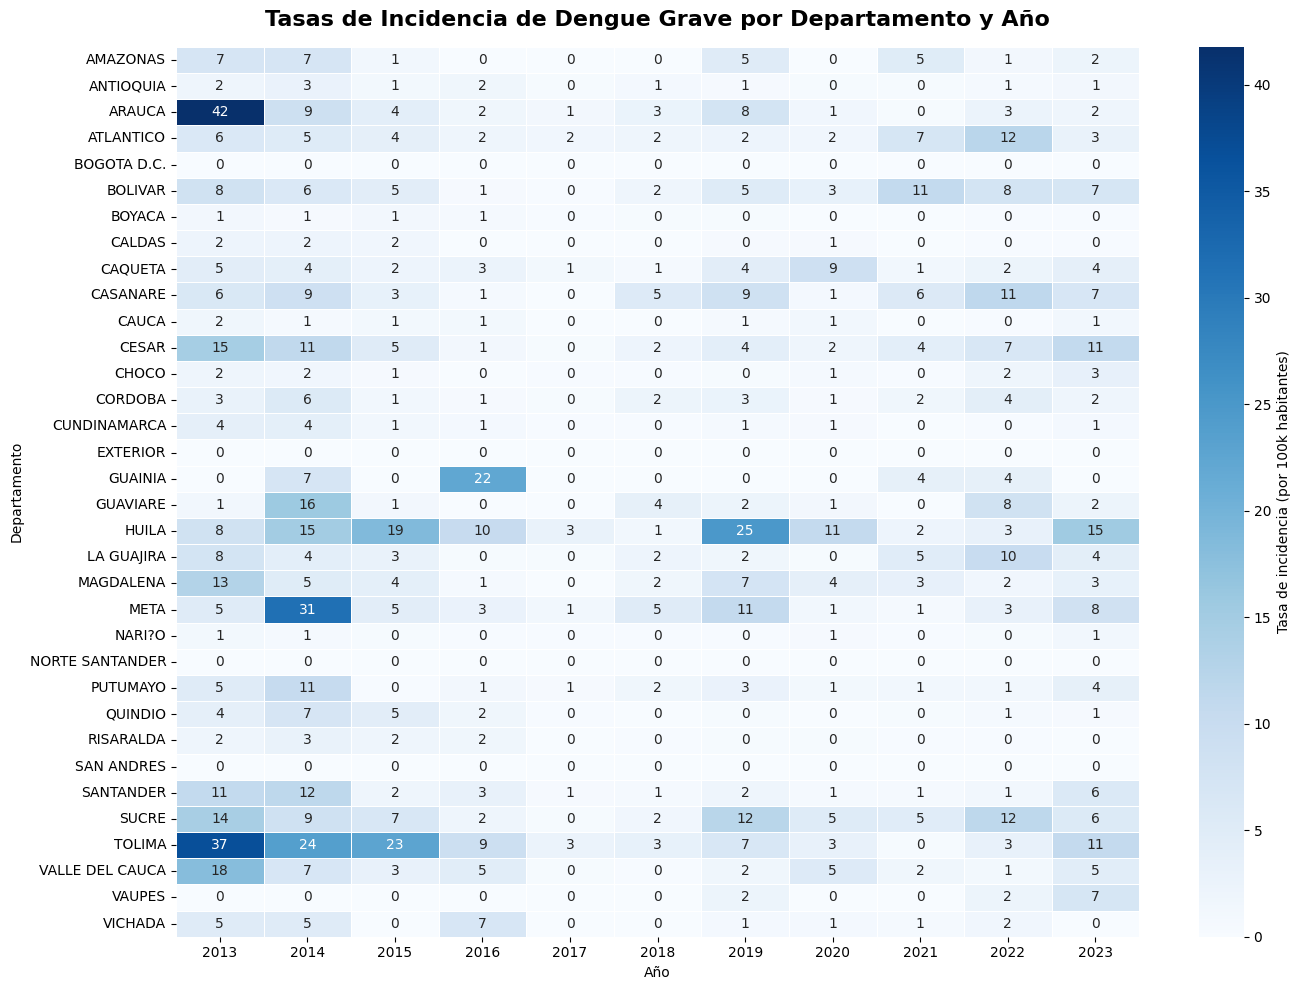

In [83]:
tabla = inc220.pivot(index="departamento", columns="ano", values="tasa_inc_100k").fillna(0)

# === 3. Graficar heatmap ===
plt.figure(figsize=(14, 10))
sns.heatmap(tabla, cmap="Blues", annot=True, fmt=".0f", linewidths=0.5, cbar_kws={'label': 'Tasa de incidencia (por 100k habitantes)'})

plt.title("Tasas de Incidencia de Dengue Grave por Departamento y Año", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Año")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()

<Figure size 1000x1200 with 0 Axes>

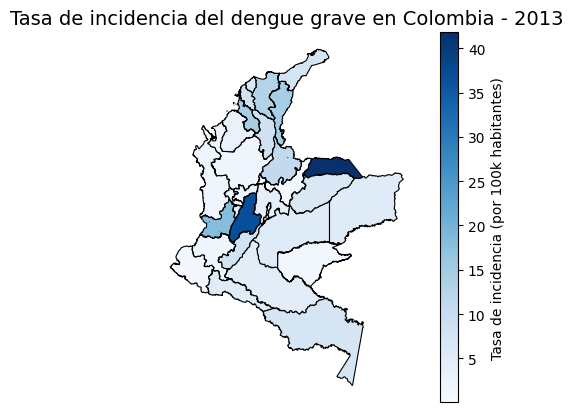

<Figure size 1000x1200 with 0 Axes>

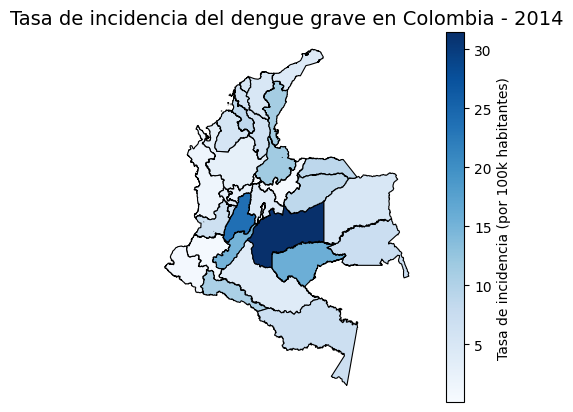

In [85]:
for anio in range(2013, 2015):
    graficar_tasa_inc_dengue(inc220, shp, anio, evento="grave")